# Proving stability of a Boolean network motif
Stability in a biological system is defined as the presence of a single fix point and no cycles (that is loops with more than one state). It can be thought of as a measure of robustness; if you believe your model represents a homoestatic system, or a system at equilibrium, we can use stability as a way to test that the model is sound. This was discussed in the previous practical about using the BMA, and Z3 is used in the BMA to prove stability in cases where the default algorithm cannot (i.e. when you are using "Further Testing").

Here we will test a small Boolean network model representing "perfect adaption"- a negative feed forward loop. In this case we are modelling it as a deterministic system; all variables update at the same time. Furthermore, we are modelling it with a constant "on" input.


## Getting started
In this section we will be using Z3 as a library. To start we will need to download the files if they are not already available. These first cells download Z3 as a zip, extract it, and load it into memory. We then reference the extracted file and open it as a module.

In [1]:
open System.Net

let wc = new WebClient()
wc.DownloadFile("https://github.com/Z3Prover/z3/releases/download/z3-4.6.0/z3-4.6.0-x64-ubuntu-16.04.zip", @"z3-4.6.0-x64-ubuntu-16.04.zip")

In [1]:
//This will take a while
#r "System.IO.Compression.FileSystem.dll"

open System;
open System.IO;
open System.IO.Compression;

if  true <> System.IO.File.Exists("z3-4.6.0-x64-ubuntu-16.04/LICENSE.txt") then ZipFile.ExtractToDirectory("z3-4.6.0-x64-ubuntu-16.04.zip", ".") else printf "Z3 already present"

Z3 already present

In [3]:
#r "z3-4.6.0-x64-ubuntu-16.04/bin/Microsoft.Z3.dll"

In [4]:
open Microsoft.Z3

## Variables and transitions

A convience function defines a new variable for Z3- *makeVariable*- based on a name (string), and a time.

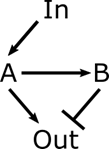

How different variables update is specified in the step function. The step function is given two times and defines new constraints, before adding them to the solver. According to the graph above, Input is constantly True or False, so the constraint *update'* specifies its state. The next state of A (at t') is set to the current state of Input (at t). B has a similar dependency on A. The output node is more complex- it is true in the next step if and only if A is true and B is false. These constraints are constructed using a "And" term (conjuction). Finally the constraints are added to the solver.



In [5]:
let makeVariable (ctx:Context) name time =
    ctx.MkBoolConst(sprintf "%s-%d" name time)

let step (ctx:Context) (s:Solver) t t' = 
    //Update input 
    let input' = ctx.MkEq((makeVariable ctx "Input" t'),ctx.MkTrue())
    //Update A 
    let a' = ctx.MkEq((makeVariable ctx "A" t'),(makeVariable ctx "Input" t))
    //Update B
    let b' = ctx.MkEq((makeVariable ctx "B" t'),(makeVariable ctx "A" t))
    //Update Output
    let output' =   ctx.MkAnd(  [|
                                ctx.MkImplies(ctx.MkEq((makeVariable ctx "A" t),(ctx.MkFalse())),ctx.MkEq((makeVariable ctx "Output" t'),ctx.MkFalse()))
                                ctx.MkImplies(ctx.MkAnd(ctx.MkEq((makeVariable ctx "A" t),ctx.MkTrue()),ctx.MkEq((makeVariable ctx "B" t),(ctx.MkFalse()))),ctx.MkEq((makeVariable ctx "Output" t'),ctx.MkTrue()))
                                ctx.MkImplies(ctx.MkAnd(ctx.MkEq((makeVariable ctx "A" t),ctx.MkTrue()),ctx.MkEq((makeVariable ctx "B" t),(ctx.MkTrue()))),ctx.MkEq((makeVariable ctx "Output" t'),ctx.MkFalse()))
                                |]  )
    s.Add(ctx.MkAnd([|input'; a'; b'; output'|]))

## Searching for stability- finding a single fixpoint

Once the transitions are defined we can start searching for the endpoints of the system. Firstly, we need to find a single fix point. If there isn't one, we can be sure that the model is unstable; however we would still need to find the cycle to be sure. To find a fix point we can specify a step where the time is the same; this effectively constrains the system to the set states that are self loops. The first answer is one fix point, but we need to know that this fix point is unique. After finding an initial solution we can then exclude this solution with a new constraint, defeined with the function *excludeState* and repeat the Check(). If this call is not satisfiable then we can be sure that there is no bifurcation in the system. It's worth noting that searching for fix points is relatively quick.

In [6]:
type result = Bifurcation | NoBifurcation | Cycle | Stable 

In [14]:
let excludeState (ctx:Context) (s:Solver) t =
    s.Add(ctx.MkNot(ctx.MkAnd(
                                [|
                                ctx.MkEq(s.Model.Eval(makeVariable ctx "Input" t),makeVariable ctx "Input" t)
                                ctx.MkEq(s.Model.Eval(makeVariable ctx "A" t),makeVariable ctx "A" t)
                                ctx.MkEq(s.Model.Eval(makeVariable ctx "B" t),makeVariable ctx "B" t)
                                ctx.MkEq(s.Model.Eval(makeVariable ctx "Output" t),makeVariable ctx "Output" t)
                                |]
    )))


let findFixpoints _ =
    let ctx = new Context()    
    let s = ctx.MkSolver()
    step ctx s 0 0
    match s.Check() with
    | Status.SATISFIABLE -> printf "Found Fixpoint\n"
                            ignore(List.map (fun name -> printf "%s:\t%O\n" name (s.Model.Eval(makeVariable ctx name 0)) ) ["Input";"A";"B";"Output"])
                            excludeState ctx s 0
                            match s.Check() with
                            | Status.UNSATISFIABLE -> printf "Only a single fixpoint\n"; NoBifurcation
                            | Status.SATISFIABLE -> printf "Found bifurcation\n"; Bifurcation
                            | _ -> failwith "Unknown result from Z3"
    | Status.UNSATISFIABLE -> printf "No fixpoints\n"; NoBifurcation
    | _ -> failwith "Unknown result from fixpoint search"

## Searching for stability- finding a cycle

The next stage is to search for cycles. We need to show that there are no cycles in the system, up to the maximum bound of the system to know that the model is stable. There are 16 states in the system (2^4) so we can use that as the maximum bound (this would not necessarily hold in an asynchronous system). To search for cycles

* We use a loop to increment the number of steps from 0 up to the current bound
* We add a constraints that the states at time 0 and time 1 are not the same (i.e. the last states are not a fixpoint)
* We add a constraint that the initial state and the final state are the same

We can then run repeated checks up to the bound of the system. Once the bound is reached, we can be confident that there are no cycles.

In [15]:
let statesEqual (ctx:Context) t t' =
    ctx.MkAnd(
        [|
        ctx.MkEq(makeVariable ctx "Input" t',makeVariable ctx "Input" t)
        ctx.MkEq(makeVariable ctx "A" t',makeVariable ctx "A" t)
        ctx.MkEq(makeVariable ctx "B" t',makeVariable ctx "B" t)
        ctx.MkEq(makeVariable ctx "Output" t',makeVariable ctx "Output" t)
        |]
    )

let statesAreEqual ctx (s:Solver) t t' = 
    s.Add(statesEqual ctx t t')
let statesAreNotEqual (ctx:Context) (s:Solver) t t' =
    s.Add(ctx.MkNot(statesEqual ctx t t'))

let findCycles bound =
    let ctx = new Context()
    let s = ctx.MkSolver()
    printf "Searching for cycles at bound"
    let rec core i bound =
        printf "...%d" i;
        step ctx s (i-1) i
        s.Push()
        //Need to assert that first state is not a fixpoint
        statesAreNotEqual ctx s 0 1
        statesAreEqual ctx s 0 i
        match s.Check() with 
        | Status.SATISFIABLE -> printf "Found cycle of length %d\n" i; Cycle
        | Status.UNSATISFIABLE -> s.Pop(); if i < bound then core (i+1) bound else printf "\n"; Stable
        | _ -> failwith "Unknown result"
    core 1 bound

## Main

Finally, run the functions! 

Run the fast test for bifurcation first (so if you find it, you can avoid the slow cycle search).

In [16]:
let main _ = 
    match findFixpoints () with
    | Bifurcation -> ()
    | _ -> match findCycles 16 with
            | Cycle -> ()
            | Stable -> printf "Model is stable!\n"
            | _ -> failwith "problem- error"

In [17]:
main ()

Found Fixpoint
Input:	true
A:	true
B:	true
Output:	false
Only a single fixpoint
Searching for cycles at bound...1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16
Model is stable!


# Exercises

1. Modify the model so that the input is constantly high, and retest. Whats the result? Does it match with what you expect?
2. Modify *step* function to change the network from a negative feedforward loop to a negative feedback loop i.e. 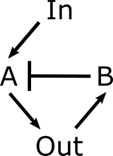. Test its stability with high and low inputs; what do you find, and is it correct?
3. Model checking like this can be optimised by adding new tests or adding additional constraints. The cycle search is slow because it searches up to the boundary of the system. In this case its 16, but for more complex networks it can be intractably large. One optimisation that the BMA has is to test whether a simulation of a given length exists and finishing the loop early. Try add this to the cycle searching code.
4. If the system was *asynchronous*, which parts of the code would have to be kept and which parts would need to be replaced? Where possible, suggest how you would modify the functions.
5. Write an *asynchonous* update function and a function that finds a simulation of length 5 using it